<a href="https://colab.research.google.com/github/AbuTalhaGT/ML-Algorithms/blob/main/CIFAR_10_image_classification_with_CNN_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook Credit : https://www.kaggle.com/code/stefancomanita/cifar-10-image-classification-with-cnn-in-pytorch

Excellent Blog to get more insight about this : https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1

### Importing the required libraries

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid

import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix


### Loading and preparing the data


In [ ]:
# Define the transformation to be applied on the dataset
transform = transforms.ToTensor()

# Download and load the CIFAR-10 training set
dataset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)

# Download and load the CIFAR-10 test set
testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:15<00:00, 11179676.85it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### 1. Check Classes in the Dataset


In [ ]:
# List of classes in CIFAR-10
print("Classes in CIFAR-10:", dataset.classes)

Classes in CIFAR-10: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### 2. Check Shape of the Dataset

In [ ]:
dataset[0][0]

tensor([[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
         [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
         [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
         ...,
         [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
         [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
         [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],

        [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
         [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
         [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
         ...,
         [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
         [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
         [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627, 0.3608]],

        [[0.2471, 0.1765, 0.1686,  ..., 0.4235, 0.4000, 0.4039],
         [0.0784, 0.0000, 0.0000,  ..., 0.2157, 0.1961, 0.2235],
         [0.0824, 0.0000, 0.0314,  ..., 0.1961, 0.1961, 0.

In [ ]:
# Get the first image and its label from the dataset
first_image, first_label = dataset[0]

# Print the shape of a single image
print("Shape of one image:", first_image.shape)

# Print the total number of images in the dataset
print("Number of images in the training set:", len(dataset))

# Similarly for the test set
print("Number of images in the test set:", len(testset))

Shape of one image: torch.Size([3, 32, 32])
Number of images in the training set: 50000
Number of images in the test set: 10000


### Split the train data into train and validate, create data loaders and define the classes and the batch size.


### 1. Setting Batch Size

**batchSize**: This variable defines the number of samples (images) that will be processed in each forward/backward pass. Here, each batch will contain 200 samples.

### 2. Splitting the Dataset

**random_split(dataset, [45000, 5000])**: The random_split function from PyTorch splits the original CIFAR-10 training dataset (dataset) into two subsets:
trainset: Contains 45,000 images (used for training).
validateset: Contains 5,000 images (used for validation).
The original CIFAR-10 training dataset contains 50,000 images, and here it's split into two parts for training and validation.

### 3. Creating DataLoader for Training and Validation Sets

**DataLoader**(trainset, batchSize, shuffle=True):

**trainset**: The training dataset (45,000 samples).
batchSize: 200 samples will be loaded per batch.
shuffle=True: Ensures the data is shuffled randomly before being passed into the model. This helps the model generalize better by seeing the data in different orders for each epoch.
DataLoader(validateset, batchSize, shuffle=True):

**validateset**: The validation dataset (5,000 samples).
batchSize: 200 samples per batch.
shuffle=True: This shuffles the validation dataset as well, but shuffling isn't as critical for validation data since it's not used for learning.

### 4. Creating DataLoader for Test Set

**DataLoader**(testset, batch_size=batchSize, shuffle=False):
testset: The CIFAR-10 test dataset (10,000 samples).
batch_size=batchSize: 200 samples per batch.
shuffle=False: Shuffling is disabled here because during testing or evaluation, you want the predictions to align with the corresponding true labels in the original order.

In [ ]:
batchSize = 200

trainset, validateset = random_split(dataset, [45000, 5000])

train = DataLoader(trainset, batchSize, shuffle=True)
validate = DataLoader(validateset, batchSize, shuffle=True)
testLoader = DataLoader(testset, batch_size=batchSize, shuffle=False)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### Display some of the images

Display some of the pictures, to verify everything is ok, and also it will make some good plots.

First let's display the first batch of 200 images from the training set.


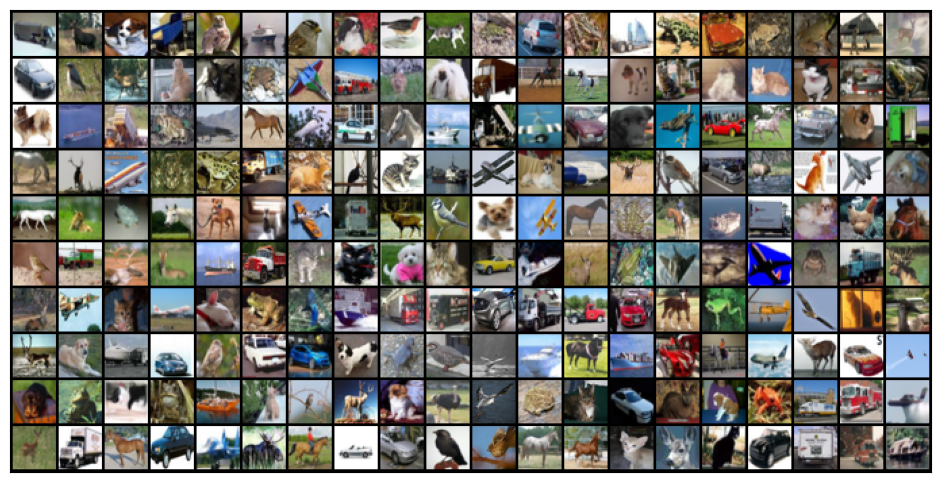

In [ ]:
for images, labels in train:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=20).permute(1, 2, 0))
    break


**make_grid** is a function from the torchvision.utils module that arranges the batch of images into a grid.

**images**: The batch of images is passed to this function.

nrow=20: Specifies that 20 images should be placed in each row of the grid.
.permute(1, 2, 0):

**In PyTorch, images are typically stored in the format (channels, height, width). However, imshow in Matplotlib expects images in the format (height, width, channels).**

**permute(1, 2, 0)** reorders the dimensions from (channels, height, width) to (height, width, channels) so that Matplotlib can correctly display the images.
ax.imshow(): Displays the grid of images on the axis ax.


### Now let's display a few of the images a little bigger, also with a their lable as a title.

### Creating a Subplot python


Creates a subplot where the image will be displayed.

(3, 4): Specifies the grid layout, meaning 3 rows and 4 columns (i.e., 12 subplots).


i+1: Specifies the position of the subplot in the grid. i+1 ensures that the subplot indices start from 1 (required by Matplotlib), so i=0 corresponds to position 1, i=1 to position 2, and so on.

Thus, each iteration of the loop places the image in the correct position within a 3x4 grid

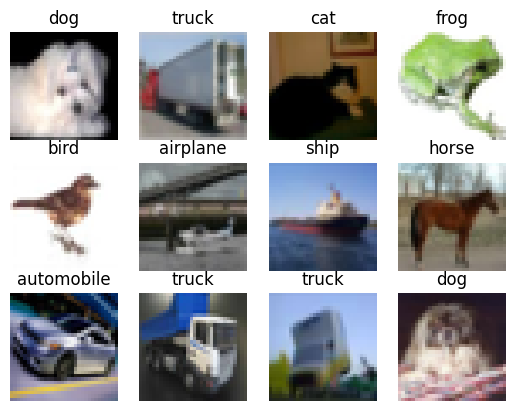

In [ ]:
for i in range(0, 12):
    img, label = validateset[i]
    plt.subplot(3,4,i+1)
    plt.title(classes[label])
    plt.axis('off')
    plt.imshow(img.permute(1, 2, 0))

###  As you can see this is a pretty hard problem, as many of the images are hard for even a human. CNNs to the rescue!



## Creating the CNN Classification Model class

We will define a class that will serve as our classification model. We will levarage the functionality provided to us by PyTorch.


## Explanation of the Cifar10Classifier CNN Model:

This class defines a Convolutional Neural Network (CNN) for classifying images from the CIFAR-10 dataset into one of 10 categories (airplane, car, bird, cat, deer, dog, frog, horse, ship, truck). Let's break down each part of the model:

### 1. Model Initialization (__init__):
The model inherits from nn.Module, which is the base class for all neural networks in PyTorch. The __init__ method initializes the network's layers using nn.Sequential() to stack layers in a sequence.

### Layers in the CNN:

- 1st Convolutional Block:

nn.Conv2d(3, 32, kernel_size=3, padding=1, stride=1): The first convolution layer takes an input with 3 channels (RGB image), outputs 32 feature maps (filters), and uses a 3x3 kernel size. The padding of 1 ensures the output size is the same as the input, and the stride of 1 moves the kernel one pixel at a time.

nn.ReLU(): ReLU activation function adds non-linearity to the network by setting all negative values to zero.

nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1): The second convolution layer takes the 32 output channels from the previous layer and outputs 64 feature maps.

nn.ReLU(): Another ReLU activation.

nn.MaxPool2d(2, 2): Max pooling reduces the spatial size of the feature maps. A 2x2 kernel with a stride of 2 is applied, which reduces both width and height by half.

- 2nd Convolutional Block:

nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1): This layer takes 64 input channels and outputs 128 feature maps.

nn.ReLU(): ReLU activation.

nn.Conv2d(128, 128, kernel_size=3, padding=1, stride=1): Another convolution layer that maintains the 128 channels.

nn.ReLU(): ReLU activation.

nn.MaxPool2d(2, 2): Max pooling again reduces the spatial size by half.

- 3rd Convolutional Block:

nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=1): This layer takes 128 input channels and outputs 256 feature maps.

nn.ReLU(): ReLU activation.

nn.Conv2d(256, 256, kernel_size=3, padding=1, stride=1): Another convolution layer that maintains the 256 channels.

nn.ReLU(): ReLU activation.

nn.MaxPool2d(2, 2): Max pooling reduces the spatial size further.


### Flatten and Fully Connected Layers:

nn.Flatten(): This flattens the 3D feature maps (channels, height, width) into a 1D vector to be fed into the fully connected layers.

nn.Linear(256 * 4 * 4, 1024): The flattened feature map of size 256 * 4 * 4 is fed into a fully connected layer with 1024 neurons.

nn.ReLU(): ReLU activation.
nn.Linear(1024, 512): A fully connected layer with 512 neurons.

nn.ReLU(): ReLU activation.
nn.Linear(512, 10): The final output layer, with 10 neurons corresponding to the 10 classes of the CIFAR-10 dataset.

---

### 2. Forward Pass (forward):
 This method defines the forward pass of the model, i.e., how the input x (an image) flows through the defined layers in self.network. The input is processed by the convolutional, pooling, flattening, and fully connected layers, and the output is a prediction of the image class.


### 3. Training Step (trainingStep):
 This method takes a batch of images and their labels as input, performs a forward pass through the model, and computes the cross-entropy loss. The cross-entropy loss is used for multi-class classification problems, and this loss is returned for backpropagation.

### 4. Validation Step (validationStep):
 This method is similar to the trainingStep, but in addition to computing the loss, it also computes the accuracy of the model predictions on the validation set. It returns a dictionary with both the loss and accuracy for the batch.

### 5. Validation Epoch End (validationEpochEnd):
 After processing all the batches in the validation set, this method computes the average loss and accuracy for the entire epoch (all batches). It aggregates the results and returns the average values.

### 6. Accuracy Calculation (accuracy):
This method calculates the accuracy of the model's predictions. It first finds the predicted class by taking the index with the maximum value in the output (logits), then compares it with the true labels to compute the accuracy


In [ ]:
class Cifar10Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        # define all the transformers sequencially
        self.network = nn.Sequential(

            # here we define 3 channels as our input, 32 channels as the output,
            # the size of the kernel, the padding and the stride
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            # apply a max pool layer
            nn.MaxPool2d(2, 2),

            # continue the process in the next two layers
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # final layer, we decrease the number of outputs to 10, which is our number of classes
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def trainingStep(self, batch):
        # unpack the images and labels from the
        images, labels = batch

        # call the model itself
        out = self(images)

        # compute the loss
        loss = F.cross_entropy(out, labels)

        return loss

    def accuracy(self, outputs, labels):
        _, preds = torch.max(outputs, dim=1)
        return torch.tensor(torch.sum(preds == labels).item() / len(preds))

    def validationStep(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        accuracy = self.accuracy(out, labels)

        return {"loss": loss, "accuracy": accuracy}

    def validationEpochEnd(self, outputs):

        batchLosses = [row["loss"] for row in outputs]
        epochLosses = torch.stack(batchLosses).mean()
        batchAcc = [row["accuracy"] for row in outputs]
        epochAcc = torch.stack(batchAcc).mean()

        return {"loss": epochLosses.item(), "accuracy": epochAcc.item()}

    def forward(self, x):
        return self.network(x)




### Training the CNN classification model

We will first define an evaluation method, a train method and then we will train our model.


In [ ]:
# the evaluation model, please note we will disable the gradiant descent on this method
@torch.no_grad()
def evaluateModel(model, validationLoader):
    # puts the model in eval mode
    model.eval()
    out = [model.validationStep(batch) for batch in validationLoader]

    return model.validationEpochEnd(out)

In [ ]:
# method for training the model
def trainModel(epochs, lr, model, trainLoader, validationLoader, optimizationFunction=torch.optim.SGD):
    optimizer = optimizationFunction(model.parameters(), lr)

    for epoch in range(epochs):
        print(f"training epoch {epoch}")
        # puts the model in train mode
        model.train()
        trainingLosses = []

        # training
        for batch in trainLoader:
            loss = model.trainingStep(batch)
            trainingLosses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print(f"after training epoch {epoch} we get results {evaluateModel(model, validationLoader)}")



Now we will instantiate the model and performn an evaluation on it, before training the model. Because the weights of the model are randomly initliasied we have an accuracy of about 10% (100% devided by the number of classes).


In [ ]:
# instantiate the model
model = Cifar10Classifier()
# do an evaluation of the model on the training
evaluateModel(model, validate)

{'loss': 2.302798271179199, 'accuracy': 0.10419999063014984}



Now let's do the training of the model


In [ ]:
%%time
trainModel(6, 0.001, model, trainLoader=train, validationLoader=validate, optimizationFunction=torch.optim.Adam)

training epoch 0
after training epoch 0 we get results {'loss': 1.4781773090362549, 'accuracy': 0.4487999677658081}
training epoch 1
after training epoch 1 we get results {'loss': 1.1410502195358276, 'accuracy': 0.589400053024292}
training epoch 2
after training epoch 2 we get results {'loss': 0.9882384538650513, 'accuracy': 0.6467999815940857}
training epoch 3
after training epoch 3 we get results {'loss': 0.9455963373184204, 'accuracy': 0.6614000201225281}
training epoch 4
after training epoch 4 we get results {'loss': 0.7704838514328003, 'accuracy': 0.7350000143051147}
training epoch 5
after training epoch 5 we get results {'loss': 0.7444410920143127, 'accuracy': 0.743399977684021}
CPU times: user 44min 3s, sys: 1min 36s, total: 45min 39s
Wall time: 22min 50s


### Predicting the image class with our trained model

First predict the accuracy for the validation dataset and then the test dataset.


In [ ]:
print(f"validation dataset accuracy: {evaluateModel(model, validate)}")

validation dataset accuracy: {'loss': 0.7444409728050232, 'accuracy': 0.743399977684021}


In [ ]:
print(f"test dataset accuracy: {evaluateModel(model, testLoader)}")

test dataset accuracy: {'loss': 0.7579497694969177, 'accuracy': 0.7408999800682068}


Let's define a new utility function to predict the label of an image based on the model.


In [ ]:
def predictImage(img, model):

    xb = img.unsqueeze(0)
    yb = model(xb)
    _, pred = torch.max(yb, dim=1)

    return pred[0].item()

Now we will plot maybe the most interesting image of the notebook, several images with the predicted and actual labels. Again we can see that the CIFAR-10 dataset is pretty hard, even for humans!

/tmp/ipykernel_36/1750769354.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 4, i + 1)


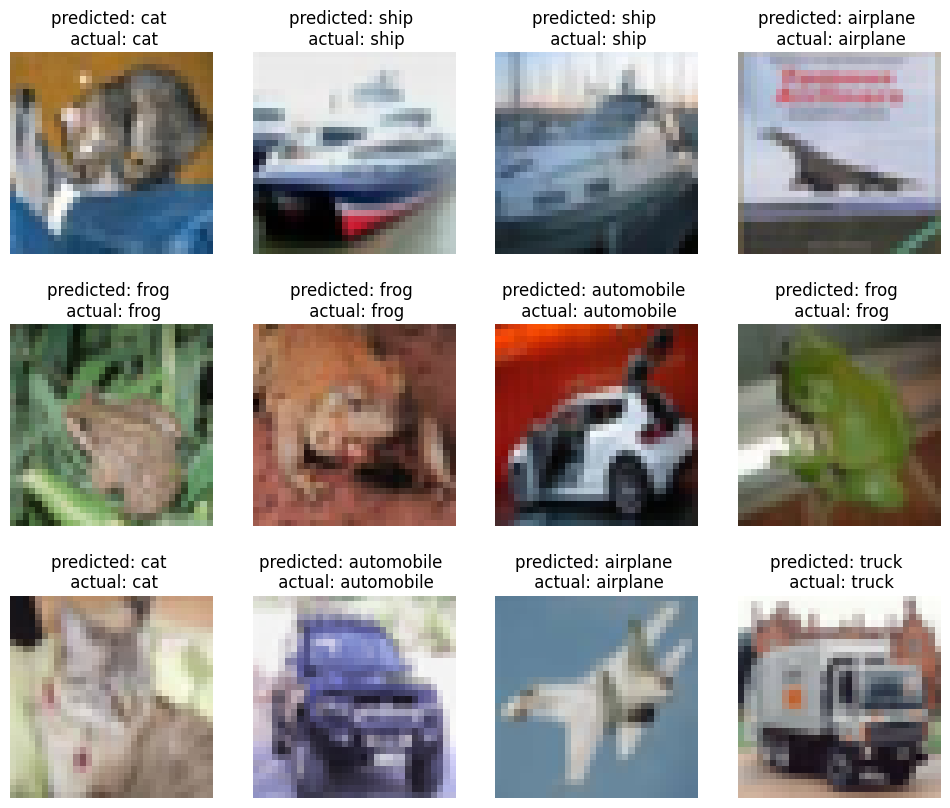

In [ ]:
%matplotlib inline
with torch.no_grad():

    plt.subplots(figsize=(12, 10))

    for i in range(0, 12):
        img, label = testset[i]

        predictedValue = predictImage(img, model)


        plt.subplot(3, 4, i + 1)
        plt.title(f"predicted: {classes[predictedValue]} \n actual: {classes[label]}")
        plt.axis('off')
        plt.imshow(img.permute(1, 2, 0))


### Confusion matrix

No classification problem is not complete without a confudion matrix, so let's make one!


In [ ]:
predictions = np.empty((0, len(testset)), np.int32)
actualValues = np.empty((0, len(testset)), np.int32)

with torch.no_grad():
    for i in range(0, len(testset)):
        testImg, testLabel = testset[i]
        predictedValue = predictImage(testImg, model)

        predictions = np.append(predictions, predictedValue)
        actualValues = np.append(actualValues, testLabel)

<Axes: >

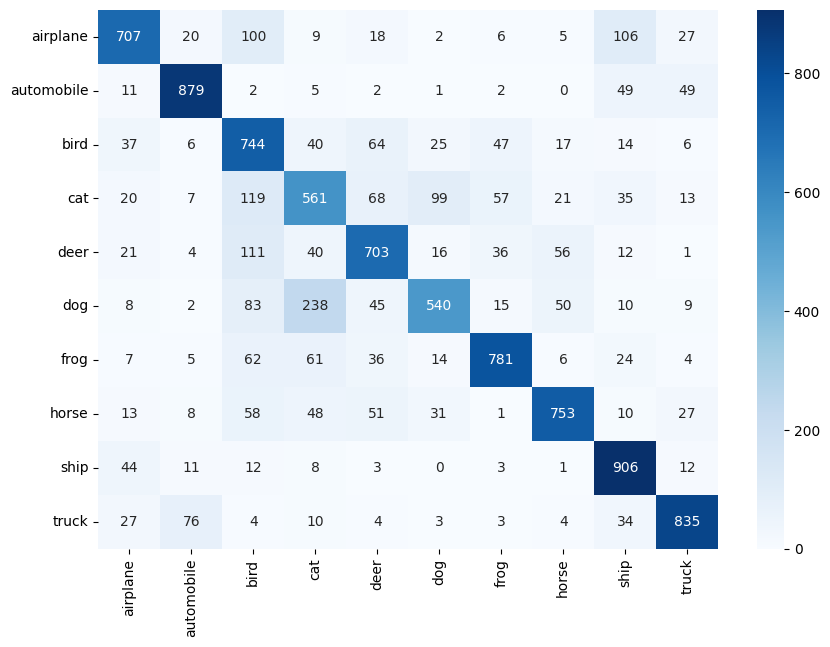

In [ ]:
confusionMatrix = confusion_matrix(actualValues, predictions)

confusionMatrixDf = pd.DataFrame(confusionMatrix, index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (10,7))
sns.heatmap(confusionMatrixDf, annot=True, cmap='Blues', fmt='g')


### Conclusion

The CIFAR-10 is a difficult data set to classify, but with CNNs we are up to the task! With PyTorch it is pretty easy to implement CNNs so our tasks is much easier.

Looking at the confusion matrix we can say that the classification of animals is the most deficult.
